In [1]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


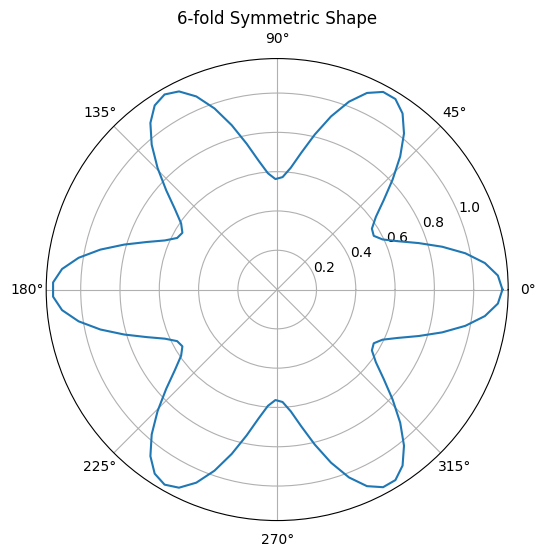

In [2]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.8
r = 0.4
n = 6
a = 0.1
L0 = 25
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
# print(polar_to_cartesian(result, theta_values))

In [3]:
ctlpts=np.array([[0.3086699843406677, 0.2758735418319702, 0.13306587934494019, 0.09701604396104813, 0.08119227737188339, 0.06854832917451859, 0.06406461447477341, 0.06046062335371971, 0.06182000786066055, 0.06557786464691162, 0.07345224171876907, 0.08943865448236465, 0.1137063056230545, 0.31442221999168396, 0.3163840174674988, 0.27724921703338623, 0.2781851589679718, 0.3106667697429657, 0.31043925881385803, 0.3011934757232666, 0.30495986342430115, 0.2973182499408722, 0.3017977774143219, 0.29241257905960083, 0.29446110129356384, 0.288280725479126, 0.28803765773773193, 0.2768099904060364, 0.26744428277015686, 0.24946291744709015, 0.2280535250902176, 0.19938169419765472, 0.1777111142873764, 0.15751978754997253, 0.13371416926383972, 0.11353771388530731, 0.07427413761615753, 0.04505261033773422, -0.004111188463866711, -0.03610575199127197, -0.07980059832334518, -0.11909311264753342, -0.15507081151008606, -0.1942921280860901, -0.24655462801456451, -0.2841857671737671, -0.3008253276348114, -0.30636364221572876, -0.3165203630924225, -0.30635136365890503, -0.30192577838897705, -0.2744407057762146, -0.20862683653831482, -0.15531882643699646, -0.09890849888324738, -0.026110095903277397, 0.0630592629313469, 0.13007815182209015, 0.1808949112892151, 0.27772846817970276, 0.29837900400161743, 0.3046216666698456, 0.30978021025657654, 0.30995556712150574], 
                 [-0.007866681553423405, 0.0011659745359793305, -0.0006445361068472266, 0.0016265674494206905, 0.0015888700727373362, 0.0016247020103037357, 0.002464885823428631, 0.0021234527230262756, 0.0031819867435842752, 0.003257128642871976, 0.004132100846618414, 0.006246301345527172, 0.006956055294722319, 0.035095974802970886, -0.0029638647101819515, 0.008828277699649334, 0.01747080124914646, 0.043627385050058365, 0.0384700633585453, 0.06743412464857101, 0.04532379284501076, 0.08196225762367249, 0.07792816311120987, 0.10453550517559052, 0.11251496523618698, 0.134861022233963, 0.14669892191886902, 0.17192590236663818, 0.1846599578857422, 0.20234885811805725, 0.2153376340866089, 0.22727960348129272, 0.24144749343395233, 0.25726574659347534, 0.27760806679725647, 0.2957572937011719, 0.3099512457847595, 0.31258973479270935, 0.3088506758213043, 0.31264472007751465, 0.3120787441730499, 0.2956472337245941, 0.26554664969444275, 0.236195370554924, 0.2128879427909851, 0.17652219533920288, 0.12058471143245697, 0.05579962953925133, -0.005813365336507559, -0.0500996969640255, -0.11806634068489075, -0.1873740553855896, -0.22226297855377197, -0.2601127326488495, -0.31236279010772705, -0.308512806892395, -0.319038450717926, -0.2825291156768799, -0.23666176199913025, -0.19422204792499542, -0.10934633761644363, -0.04857693240046501, -0.00442955456674099, -0.001773270545527339]])

weights = np.array([[0.018801717087626457, 0.007159950211644173, 0.011893989518284798, 0.012241690419614315, 0.012400703504681587, 0.012449154630303383, 0.012477702461183071, 0.012498417869210243, 0.01247803121805191, 0.012454690411686897, 0.012363936752080917, 0.01209452748298645, 0.005604941863566637, 0.012242992408573627, 0.011078317649662495, 0.012254590168595314, 0.009681268595159054, 0.015415523201227188, 0.011888593435287476, 0.013117319904267788, 0.011186577379703522, 0.0111227473244071, 0.012261984869837761, 0.011775173246860504, 0.013226679526269436, 0.01331684272736311, 0.011767424643039703, 0.012591368518769741, 0.010729041881859303, 0.011704988777637482, 0.012284437194466591, 0.010726237669587135, 0.010083748959004879, 0.012550857849419117, 0.01142387930303812, 0.011547515168786049, 0.012113194912672043, 0.011329338885843754, 0.010816275142133236, 0.01032005064189434, 0.010109327733516693, 0.009152832441031933, 0.009471431374549866, 0.009114403277635574, 0.008530695922672749, 0.009079741314053535, 0.010893414728343487, 0.010365035384893417, 0.0079995421692729, 0.00862112082540989, 0.010522689670324326, 0.010575272142887115, 0.009920626878738403, 0.00880669616162777, 0.009529183618724346, 0.009453858248889446, 0.007149068173021078, 0.005881322547793388, 0.006904789246618748, 0.006862286012619734, 0.008870360441505909, 0.013639145530760288, 0.017785869538784027, 0.012431884184479713]])
print(weights.shape)
ctlpts = np.hstack([ctlpts, ctlpts[:, 0].reshape(2, 1)])
weights = np.append(weights, weights[0][0])
print(weights.shape)


(1, 64)
(65,)


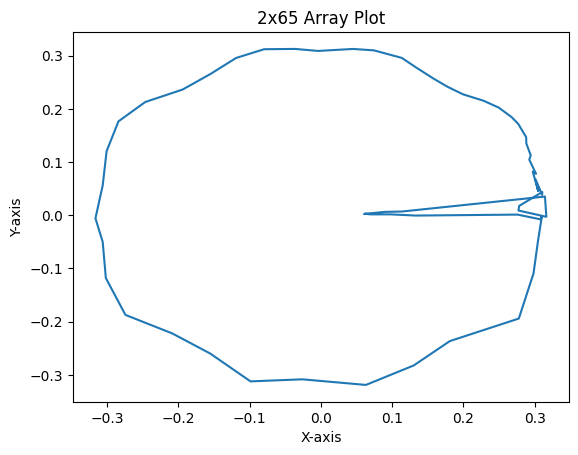

In [4]:
# Plot the data
plt.plot(ctlpts[0], ctlpts[1])

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2x65 Array Plot')

# Show the plot
plt.show()

65
(65, 2)
(65,)
(65,)
(65,)


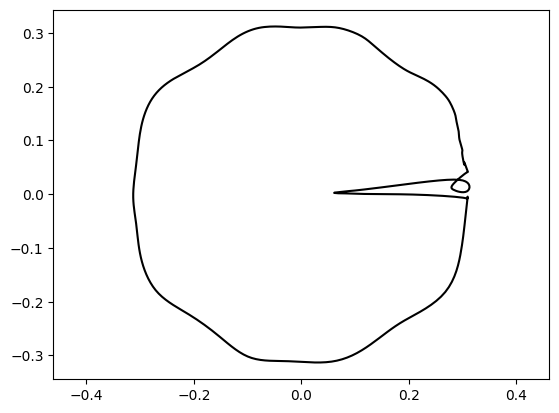

In [5]:
from pyiga.geometry import *
from pyiga import approx, bspline
n_kv = 62
kv = bspline.make_knots(3, 0.0, 1.0, n_kv)
# N = tuple(kv.numdofs for kv in kvs)
r = 2.0
num_res = kv.numdofs
print(num_res)
# construct quarter circle using NURBS
theta_values = np.linspace(0, 2 * np.pi, num_res)
result = superformula(theta_values, r, d, n, a, L0)
# coeff = np.array(polar_to_cartesian(result, theta_values)).transpose()
# w = np.ones((1,num_res))
# coeff = np.vstack((coeff, w)).transpose()
coeff = ctlpts.transpose()
grid = (np.linspace(0.0, 1.0, 100),)
print(coeff.shape)
print(weights.shape)
weights = weights.transpose().reshape(65)
print(weights.shape)
# weights = np.random.random(coeff.shape[0])*5
# weights = np.ones(coeff.shape[0])
N = tuple(kv.numdofs for kv in (kv,))
# print(N)
nurbs = NurbsFunc((kv,), coeff.copy(), weights=weights)
vals = nurbs.grid_eval(grid)

vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
axis('equal');


In [6]:
print(type(grid))
grid[0]

<class 'tuple'>


array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [7]:
vals = nurbs.grid_eval(grid)


In [8]:
coeff.shape

(65, 2)

In [9]:
# grid = (np.linspace(0.0, 1.0, 100),)

# vals = nurbs.grid_eval(grid)

# ev = np.linspace(-1.0, 1.0, 10).reshape(1,10)
# resu = nurbs.pointwise_eval(ev)

In [10]:
import numpy as np
from scipy.interpolate import BSpline

def extract_bezier_curve(control_points, weights, knot_vector, degree, i):
    """
    Extracts the Bezier curve from the NURBS curve in the given knot interval [a, b].
    """
    # Extract control points and weights for the Bezier curve
    bezier_points = control_points[i:i+degree+1]
    bezier_weights = weights[i:i+degree+1]
    # Normalize the control points by the weights
    weighted_points = bezier_points * bezier_weights[:, np.newaxis]
    # Extract the knot interval [a, b]
    a, b = knot_vector[i], knot_vector[i+1]
    
    return BSpline(knot_vector[i:i+degree+3], weighted_points, degree), a, b

def find_parameter_value(nurbs_curve, control_points, weights, knot_vector, degree, X0):
    """
    Finds the parameter value corresponding to the given X0 in the NURBS curve.
    """
    num_intervals = len(knot_vector) - degree - 1
    
    for i in range(num_intervals):
        # Extract the Bezier curve and knot interval [a, b]
        bezier_curve, a, b = extract_bezier_curve(control_points, weights, knot_vector, degree, i)
        
        # Calculate the X-min and X-max for the current Bezier curve's control points
        Xmin, Xmax = np.min(bezier_curve.c[:, 0]), np.max(bezier_curve.c[:, 0])
        
        if X0 >= Xmin and X0 <= Xmax:
            t0, t1 = a, b
            epsilon = 1.0e-06
            
            while (t1 - t0) > epsilon:
                # Subdivide the Bezier curve at t=0.5
                t_mid = (t0 + t1) / 2
                B1, B2 = bezier_curve(t0), bezier_curve(t_mid), bezier_curve(t1)
                
                # Compute X-min and X-max for both subdivided curves
                Xmin1, Xmax1 = np.min(B1[:, 0]), np.max(B1[:, 0])
                Xmin2, Xmax2 = np.min(B2[:, 0]), np.max(B2[:, 0])
                
                if X0 >= Xmin1 and X0 <= Xmax1:
                    bezier_curve = B1
                    t1 = t_mid
                else:
                    bezier_curve = B2
                    t0 = t_mid
            
            # Return the parameter value corresponding to X0
            return (t0 + t1) / 2
    
    return None  # Return None if X0 is not found in any knot interval

In [11]:
ctlpts = np.array([[0.48555564880371094, 0.461707204580307, 0.4488178491592407, 0.4529491364955902, 
           0.45946311950683594, 0.4788070619106293, 0.4872964322566986, 0.4816374182701111, 
           0.4854227602481842, 0.4902132451534271, 0.49531835317611694, 0.507867693901062,
           0.5346999168395996, 0.5879551768302917, 0.7011892795562744, 0.6726462244987488,
           0.46186813712120056, 0.3711071014404297, 0.3387696146965027, 0.26965463161468506,
           0.09419172257184982, -0.08759941905736923, 0.18708324432373047, 0.19953271746635437,
           -0.0013188637094572186, -0.05136439576745033, 0.3346371352672577, 0.47256091237068176,
           0.796478807926178, 0.5115493535995483, 0.4795879125595093, 0.48260465264320374],
          [0.003558018244802952, -0.0030079197604209185, -0.0057970271445810795, -0.00400342233479023,
           -0.006246759090572596, -0.006358697544783354, 2.5723129510879517e-06, -0.0004138620279263705,
           0.012208137661218643, 0.01625647582113743, 0.03646162524819374, 0.06094575300812721,
           0.0949007198214531, 0.16090194880962372, 0.3151451051235199, 0.37135884165763855,
           0.21077172458171844, 0.1590133011341095, 0.13978002965450287, 0.15379546582698822,
           0.332438588142395, 0.38076522946357727, 0.037919897586107254, -0.03015035204589367,
           -0.1979031264781952, -0.44769662618637085, -0.12772612273693085, -0.25168296694755554,
           -0.43906649947166443, -0.08002528548240662, -0.011266911402344704, 0.0026920977979898453]])
weights = np.array([0.10123608261346817, 0.09858367592096329, 0.10119597613811493, 0.09971634298563004,
           0.09576867520809174, 0.09801937639713287, 0.13111865520477295, 0.09775735437870026,
           0.12425547093153, 0.08091424405574799, 0.09052342921495438, 0.09468352049589157,
           0.07757404446601868, 0.05204970762133598, 0.032695792615413666, 0.03474508225917816,
           0.0779278427362442, 0.13388802111148834, 0.14278794825077057, 0.09959631413221359,
           0.037657059729099274, 0.06631699204444885, 0.1726970076560974, 0.11162034422159195,
           0.0279964879155159, 0.0565689317882061, 0.15092866122722626, 0.01478570606559515,
           0.032932814210653305, 0.06922388076782227, 0.1949511617422104, 0.0984344482421875])

In [12]:
ctlpts = np.array([[0.4945697784423828, 0.4863211214542389, 0.4901614785194397, 0.509587824344635, 
           0.5258923172950745, 0.5478668212890625, 0.5569302439689636, 0.4842439293861389,
           0.4300110638141632, 0.34704163670539856, 0.3117505609989166, 0.2896122336387634,
           0.25792765617370605, 0.20764131844043732, 0.10684122145175934, -0.025508040562272072,
           -0.023301197215914726, 0.13246791064739227, 0.22284379601478577, 0.2544543743133545,
           0.27830368280410767, 0.30574706196784973, 0.3374943137168884, 0.4015735387802124,
           0.4509890377521515, 0.5557920336723328, 0.5545370578765869, 0.5262722373008728,
           0.528229832649231, 0.4955866038799286, 0.4930431842803955, 0.5043909549713135],
            [0.006959728430956602, 0.01239315327256918, 0.03743232786655426, 0.07845724374055862, 
             0.12131121009588242, 0.20895498991012573, 0.32904645800590515, 0.3210972845554352, 
             0.2605370581150055, 0.18598805367946625, 0.1483028382062912, 0.12147330492734909, 
             0.11096946150064468, 0.09714686125516891, 0.08834633976221085, 0.02548958547413349, 
             -0.03300272673368454, -0.07940245419740677, -0.09394693374633789, -0.10086223483085632, 
             -0.11003636568784714, -0.1330055147409439, -0.16766637563705444, -0.22875435650348663, 
             -0.2886456847190857, -0.33983439207077026, -0.18895328044891357, -0.11168479919433594, 
             -0.09326477348804474, -0.033122718334198, 0.0001156926155090332, 0.006309317424893379]])
weights = np.array([0.0025300905108451843, 0.00357867986895144, 0.0037845997139811516, 0.002744589699432254,
            0.0023298030719161034, 0.0017924911808222532, 0.0013510570861399174, 0.0007019041804596782,
            0.0013908531982451677, 0.003288048319518566, 0.004029596224427223, 0.00428433483466506,
            0.003543122671544552, 0.0042422316037118435, 0.00375157268717885, 0.0034774953965097666,
            0.0032558708917349577, 0.00624815421178937, 0.005322189535945654, 0.002714200410991907,
            0.004167245700955391, 0.005131041165441275, 0.0038470199797302485, 0.0018886413890868425,
            0.0012587191304191947, 0.001832924666814506, 0.0016237969975918531, 0.00048126012552529573,
            0.0017591043142601848, 0.005036474205553532, 0.003983697853982449, 0.0024836729280650616])

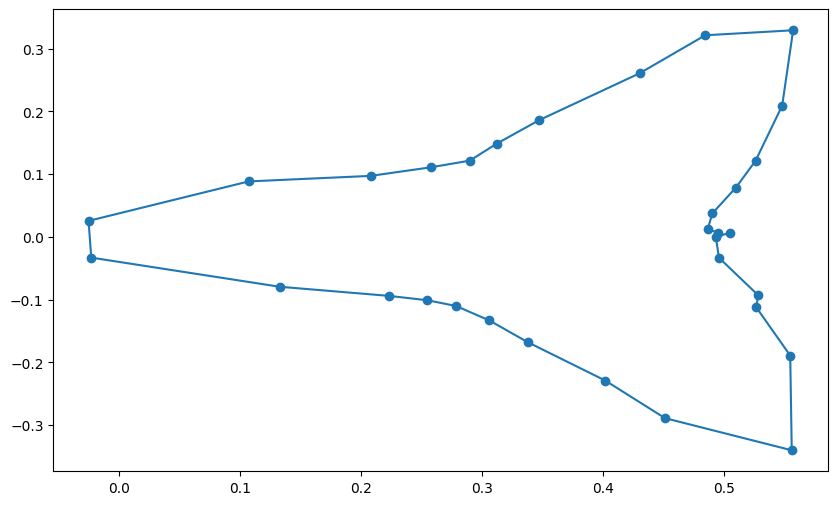

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(ctlpts.transpose()[:, 0], ctlpts.transpose()[:, 1], 'o-', label='32x2 Data')

In [14]:
weights.shape

(32,)

101
2
(101,)
(101,)


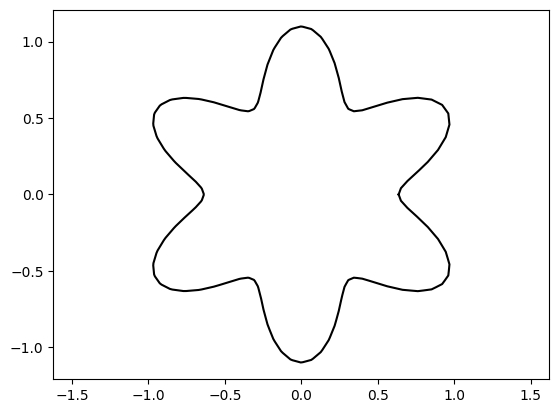

In [15]:
from pyiga.geometry import *
from pyiga import approx, bspline
n_kv = 100
kv = bspline.make_knots(1, 0.0, 1.0, n_kv)
# N = tuple(kv.numdofs for kv in kvs)
r = 2.0
num_res = kv.numdofs
print(num_res)
# construct quarter circle using NURBS
theta_values = np.linspace(0, 2 * np.pi, num_res)
result = superformula(theta_values, r, d, n, a, L0)
coeff = np.array(polar_to_cartesian(result, theta_values)).transpose()
# w = np.ones((1,num_res))
# coeff = np.vstack((coeff, w)).transpose()
# coeff = ctlpts.transpose()
grid = (np.linspace(0.0, 1.0, 100),)
print(coeff.shape[1])
# weights = weights.transpose()
# weights = np.random.random(coeff.shape[0])*5
weights = np.ones(coeff.shape[0])
N = tuple(kv.numdofs for kv in (kv,))
print(N)
nurbs = NurbsFunc((kv,), coeff.copy(), weights=weights)
vals = nurbs.grid_eval(grid)

vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
axis('equal');


In [16]:
# grid = (np.linspace(0.0, 1.0, 100),)

# vals = nurbs.grid_eval(grid)

# ev = np.linspace(-1.0, 1.0, 10)
# resu = nurbs.pointwise_eval(coeff.transpose())

In [17]:
# nurbs.find_inverse(1)

In [18]:
coeff.shape

(101, 2)

(3,)
(3,)
(3,)
grid eval from bspline function is used
(2,)
(3, 2)
(2,)
(3, 2)


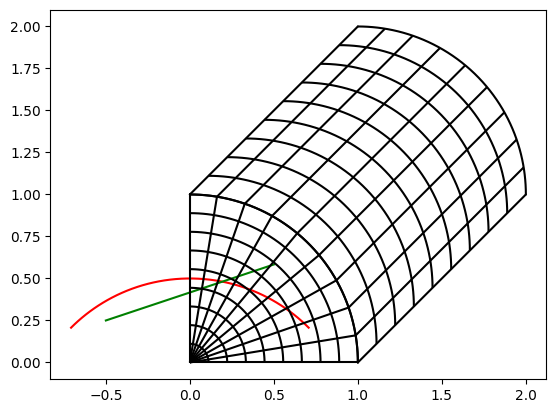

In [19]:
f = geometry.circular_arc(pi/2)
g = geometry.line_segment([0,0], [1,1])
vis.plot_geo(f.rotate_2d(pi/4).translate([0,-0.5]), color='red')
vis.plot_geo(g.scale([1,1/3]).translate([-.5,.25]), color='green')
axis('equal');
vis.plot_geo(geometry.outer_sum(f, g))
axis('equal');
vis.plot_geo(geometry.outer_product(f, g))
axis('equal');


(101,)
(101, 101)


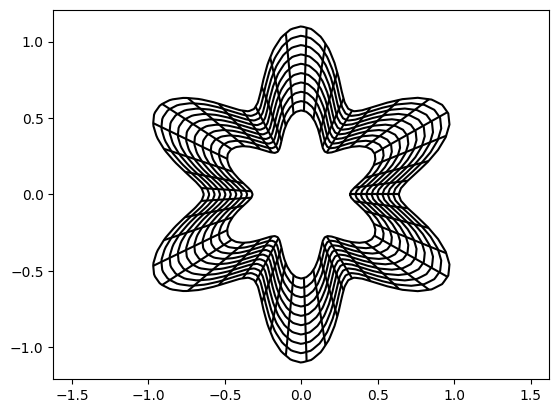

In [20]:
g = geometry.line_segment([0.5,0.5], [1,1], intervals=100)
geo = geometry.outer_product(nurbs, g)
grid = (np.linspace(0.0, 1.0, 8),)
vis.plot_geo(geo, gridx = 50, gridy = 10, grid = grid, res = 400)
axis('equal');

In [21]:
geo.coeffs.shape

(101, 101, 3)

In [22]:
# grid = (np.linspace(0.0, 1.0, 100),)

# vals = nurbs.grid_eval(grid)

# ev = np.linspace(-1.0, 1.0, 10)
# resu = geo.pointwise_eval(ev)

In [23]:
geo.kvs

(KnotVector(array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
        0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
        0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
        0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
        0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
        0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
        0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
        0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
        0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
        0.98, 0.99, 1.  , 1.  ]), 1),
 KnotVector(array([0.  , 0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
        0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
        0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
        0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.

In [24]:
geo.coeffs.shape

(101, 101, 3)

grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used


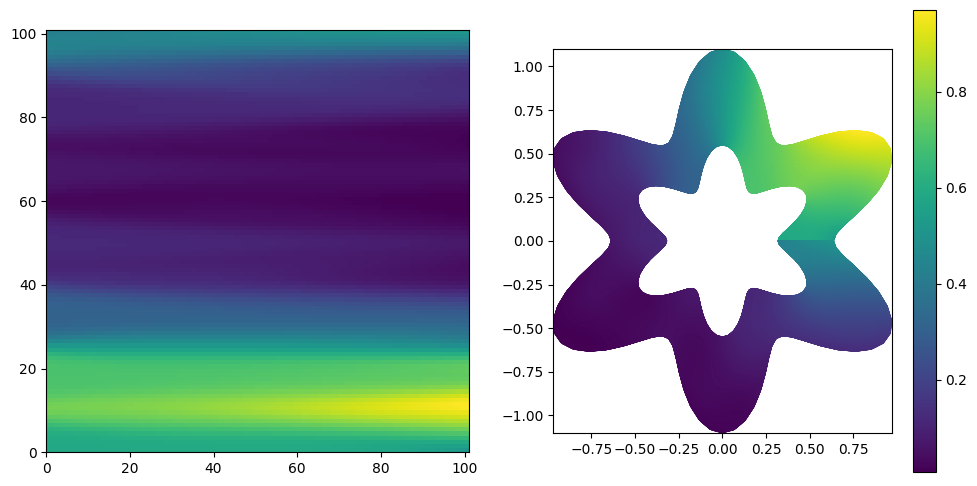

In [28]:
g = lambda x,y: np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: 3 * np.sin(10*x) * np.cos(10*y) # source term
kvs = geo.kvs
# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('right', g), ('top', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 500)
gca().set_aspect('equal')
colorbar();

grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used


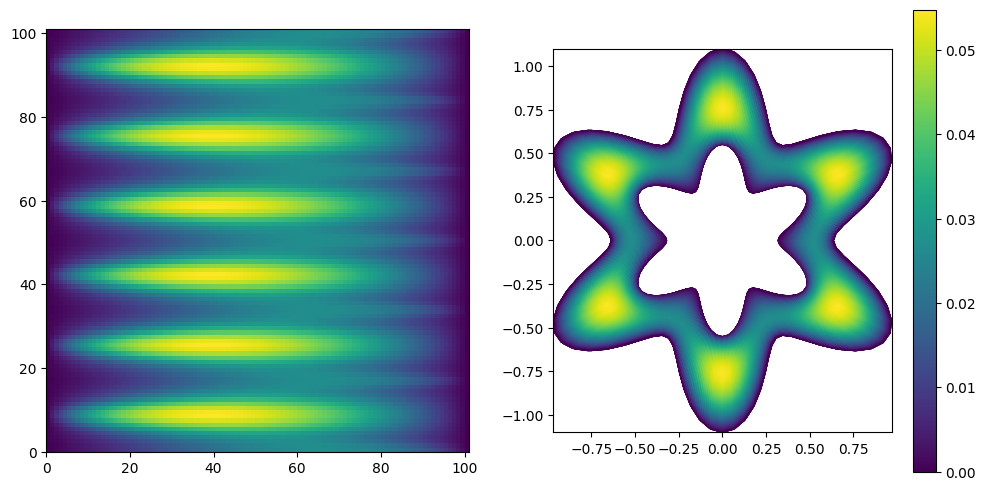

In [26]:
g = lambda x,y: 0  # Dirichlet BC function
f = lambda x,y: 3 # source term

# compute Dirichlet boundary conditions
bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
# set up and solve linear system
A = assemble.stiffness(kvs, geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo, res = 500)
gca().set_aspect('equal')
colorbar();

In [27]:
u.shape

(9999,)